<a href="https://colab.research.google.com/github/listakurniawati/Sentiment-Analysis-of-Edutech-Start-Up-using-CNN-BiLSTM/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, LSTM
from keras.models import Sequential
from keras.preprocessing import text
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# **Upload Data**

In [ ]:
quipper_df = pd.read_csv('https://raw.githubusercontent.com/Syamsyuriani/Scrapping_Data/main/Quipper-Data_labelled.csv')

In [ ]:
quipper_df.columns

Index(['review', 'label', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')

In [ ]:
review = quipper_df.drop(columns=['Unnamed: 2', 'Unnamed: 3'])
review

,review,label
0,Apk Quipper sangat membantu dalam memahami pel...,-1
1,"Penjelasannya bagus, tutornya juga enak ngejel...",-1
2,"Tolong dong quipper, saya lagi ngerjain soal a...",-1
3,"Banyak bug. klo matematika, fisika, kimia ,Jaw...",-1
4,"Aplikasinya kurang menarik, pembahasan nya lam...",-1
...,...,...
6074,Gimana cara masukin soal?,-1
6075,Amit jangan donwlod nyesel,-1
6076,cari kode kelasnya dimanaaa..,-1
6077,Harus bayar paketnya,-1


In [ ]:
# Menghapus duplikat
dt = review.drop_duplicates(subset=['review'], keep='last', inplace=False).reset_index()
df = dt.drop(['index'], axis=1)
df

,review,label
0,Apk Quipper sangat membantu dalam memahami pel...,-1
1,"Penjelasannya bagus, tutornya juga enak ngejel...",-1
2,"Tolong dong quipper, saya lagi ngerjain soal a...",-1
3,"Banyak bug. klo matematika, fisika, kimia ,Jaw...",-1
4,"Aplikasinya kurang menarik, pembahasan nya lam...",-1
...,...,...
4682,Gimana cara masukin soal?,-1
4683,Amit jangan donwlod nyesel,-1
4684,cari kode kelasnya dimanaaa..,-1
4685,Harus bayar paketnya,-1


In [ ]:
negative = df[df['label']==-1].count()[0]
positive = df[df['label']==1].count()[0]

Text(0.5, 1.0, 'Diagram Lingkaran Data Analisis Sentimen')

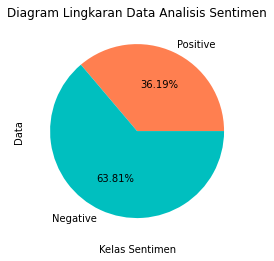

In [ ]:
labels = ['Positive','Negative']
Category1 = [str(positive),str(negative)]
plt.pie(Category1, labels=labels, autopct='%1.2f%%', colors=['coral', 'c'])
plt.xlabel('Kelas Sentimen')
plt.ylabel('Data')
plt.title('Diagram Lingkaran Data Analisis Sentimen')

Text(0.5, 1.0, 'Diagram Bar Data Analisis Sentimen')

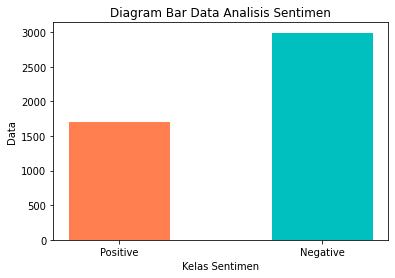

In [ ]:
labels = ['Positive','Negative']
Category1 = [positive, negative]
plt.bar(labels, Category1, tick_label=labels, width=0.5, color=['coral', 'c'])
plt.xlabel('Kelas Sentimen')
plt.ylabel('Data')
plt.title('Diagram Bar Data Analisis Sentimen')

# ***Pre-processing***

In [ ]:
#PEMBERSIHAN(CLEANING DATA)
stopwords = pd.read_csv("https://raw.githubusercontent.com/listakurniawati/COVID-19-With-SVM/main/stopwords_id.csv?token=ARCQD7EZ55J4TUTAWYYLYOTAX3FTW")
stopwords = np.append(stopwords, "rt")
 
def clean_text(tweet):
 
    # Convert to lower case
    tweet = tweet.lower()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove punctuation
    tweet = re.sub(r'[^\w\s]',' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove punctuation
    tweet = re.sub(r'[^\w\s]',' ', tweet)
    #Clean number
    tweet = re.sub(r'[\d-]', '', tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #trim
    tweet = tweet.strip('\'"')
    # Clean per Words
    words = tweet.split()
    tokens=[]
    for ww in words:
        #split repeated word
        for w in re.split(r'[-/\s]\s*', ww):
            #replace two or more with two occurrences
            pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
            w = pattern.sub(r"\1\1", w)
            #strip punctuation
            w = w.strip('\'"?,.')
            #check if the word cosists of two or more alphabets
            val = re.search(r"^[a-zA-Z][a-zA-Z][a-zA-Z]*$", w)
            #add tokens
            if(w in stopwords or val is None):
                continue
            else:
                tokens.append(w.lower())
    
    tweet = " ".join(tokens)
    return tweet

In [ ]:
df['label'] = df['label'].replace(-1,0)

In [ ]:
df['review'] = df['review'].map(lambda x: clean_text(x))
df = df[df['review'].apply(lambda x: len(x.split()) >=1)]
df

,review,label
0,apk quipper membantu memahami pelajaran solusi...,0
1,penjelasannya bagus tutornya enak ngejelasinny...,0
2,tolong quipper ngerjain tryout aplikasi koneks...,0
3,bug klo matematika fisika kimia fail loaded,0
4,aplikasinya menarik pembahasan nya banget gak ...,0
...,...,...
4682,gimana masukin,0
4683,amit donwlod nyesel,0
4684,cari kode kelasnya dimanaa,0
4685,bayar paketnya,0


In [ ]:
#tokenisasi
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['review'])

In [ ]:
sequences = tokenizer.texts_to_sequences(df['review'])
x = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=80)
y = np.array((df['label']))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [ ]:
seq_length = x.shape[1]
print(seq_length)
vocab_size = len(tokenizer.index_word) + 1
print(vocab_size)

80
5615


# **Model CNN BiLSTM**

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 102kB 4.8MB/s 


In [ ]:
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization
 
def cnn_bilstm(hp):
 
    ### Arsitektur
 
    #Input layer
    inputs = keras.layers.Input(shape=(seq_length,))
 
    #Embedding
    embedding = keras.layers.Embedding(input_dim = vocab_size,
                                       output_dim = hp.Choice('embedding_size', values = [64, 100, 128]))(inputs)
 
    #Convolution layer
    ngram_1 = keras.layers.Conv1D(filters = hp.Int('filters1',
                                                min_value = 200, 
                                                max_value = 300, 
                                                step = 50),
                                  kernel_size = hp.Int('kernel_size1',
                                                min_value = 3, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn1',
                                                                                       values = [0.0, 0.01])))(embedding)
    ngram_2 = keras.layers.Conv1D(filters = hp.Int('filters2',
                                                min_value = 200, 
                                                max_value = 300, 
                                                step = 50),
                                  kernel_size = hp.Int('kernel_size2',
                                                min_value = 3, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn2',
                                                                                       values = [0.0, 0.01])))(embedding)
    ngram_3 = keras.layers.Conv1D(filters = hp.Int('filters3',
                                                min_value = 200, 
                                                max_value = 300, 
                                                step = 50),
                                  kernel_size = hp.Int('kernel_size3',
                                                min_value = 3, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn3',
                                                                                       values = [0.0, 0.01])))(embedding)
    ngram_4 = keras.layers.Conv1D(filters = hp.Int('filters4',
                                                min_value = 200, 
                                                max_value = 300, 
                                                step = 50),
                                  kernel_size = hp.Int('kernel_size4',
                                                min_value = 3, 
                                                max_value = 5, 
                                                step = 1),
                                  activation='relu',
                                  kernel_regularizer = keras.regularizers.l2(hp.Choice('kernel_cnn4',
                                                                                       values = [0.0, 0.01])))(embedding)
 
    #Max Pooling layer
    ngram_1 = keras.layers.GlobalMaxPooling1D()(ngram_1)
    ngram_2 = keras.layers.GlobalMaxPooling1D()(ngram_2)
    ngram_3 = keras.layers.GlobalMaxPooling1D()(ngram_3)
    ngram_4 = keras.layers.GlobalMaxPooling1D()(ngram_4)
    merged = keras.layers.Concatenate(axis=1)([ngram_1, ngram_2, ngram_3, ngram_4])
 
    #BiLSTM layer
    bilstm1 = keras.layers.Layer(LSTM(units = hp.Int('units1',
                                                     min_value = 100,
                                                     max_value = 200,
                                                     step = 50),
                                      kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_regularizer1',
                                                                                         values = [0.0, 0.01])),
                                      recurrent_regularizer=keras.regularizers.l2(hp.Choice('rec_regularizer1',
                                                                                            values = [0.0, 0.01])),
                                      return_sequences = True))(merged)
    bilstm2 = keras.layers.Layer(LSTM(units = hp.Int('units2',
                                                     min_value = 100,
                                                     max_value = 200,
                                                     step = 50),
                                      kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_regularizer2',
                                                                                         values = [0.0, 0.01])),
                                      recurrent_regularizer=keras.regularizers.l2(hp.Choice('rec_regularizer2',
                                                                                            values = [0.0, 0.01])),
                                      return_sequences = True, go_backwards=True))(bilstm1)
    
    #Dropout layer
    lstm_out = keras.layers.Dropout(0.25)(bilstm2)
 
    #Output layer
    output = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(hp.Choice('kernel_dense', values = [0.0, 0.01])))(lstm_out)
    model = keras.models.Model(inputs=inputs, outputs=output)
 
    model.compile(optimizer = keras.optimizers.Adam(
                              hp.Choice('learning_rate', 
                                        values = [1e-2, 1e-3, 1e-4])),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
 
    return model
 
tuner = BayesianOptimization(cnn_bilstm,
                             objective = 'val_accuracy', 
                             max_trials = 10,
                             directory = 'Hasil',
                             project_name = 'Sentimen_CNN-BiLSTM')
 
tuner.search(x_train, y_train, batch_size=32, epochs = 10, validation_data = (x_test, y_test))
 
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
 
print('\nThe hyperparameter search is complete. \nembedding_size:', best_hps.get('embedding_size'),
      '\nfilters:', [best_hps.get('filters1'), best_hps.get('filters2'), best_hps.get('filters3'), best_hps.get('filters4')],
      '\nkernel_size:', [best_hps.get('kernel_size1'), best_hps.get('kernel_size2'), best_hps.get('kernel_size3'), best_hps.get('kernel_size4')],
      '\nkernel_cnn:', [best_hps.get('kernel_cnn1'), best_hps.get('kernel_cnn2'), best_hps.get('kernel_cnn3'), best_hps.get('kernel_cnn4')],
      '\nunit:', [best_hps.get('units1'), best_hps.get('units2')],
      '\nkernel_regularizer:', [best_hps.get('kernel_regularizer1'), best_hps.get('kernel_regularizer2')],
      '\nrec_regularizer:', [best_hps.get('rec_regularizer1'), best_hps.get('rec_regularizer2')],
      '\nkernel_dense:', best_hps.get('kernel_dense'),
      '\nLearning rate:', best_hps.get('learning_rate'))

Trial 10 Complete [00h 04m 23s]
val_accuracy: 0.8936627507209778

Best val_accuracy So Far: 0.9044038653373718
Total elapsed time: 00h 44m 21s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
embedding_size: 128 
filters: [300, 250, 300, 250] 
kernel_size: [4, 5, 4, 3] 
kernel_cnn: [0.01, 0.01, 0.0, 0.01] 
unit: [200, 100] 
kernel_regularizer: [0.0, 0.01] 
rec_regularizer: [0.01, 0.0] 
kernel_dense: 0.0 
Learning rate: 0.0001


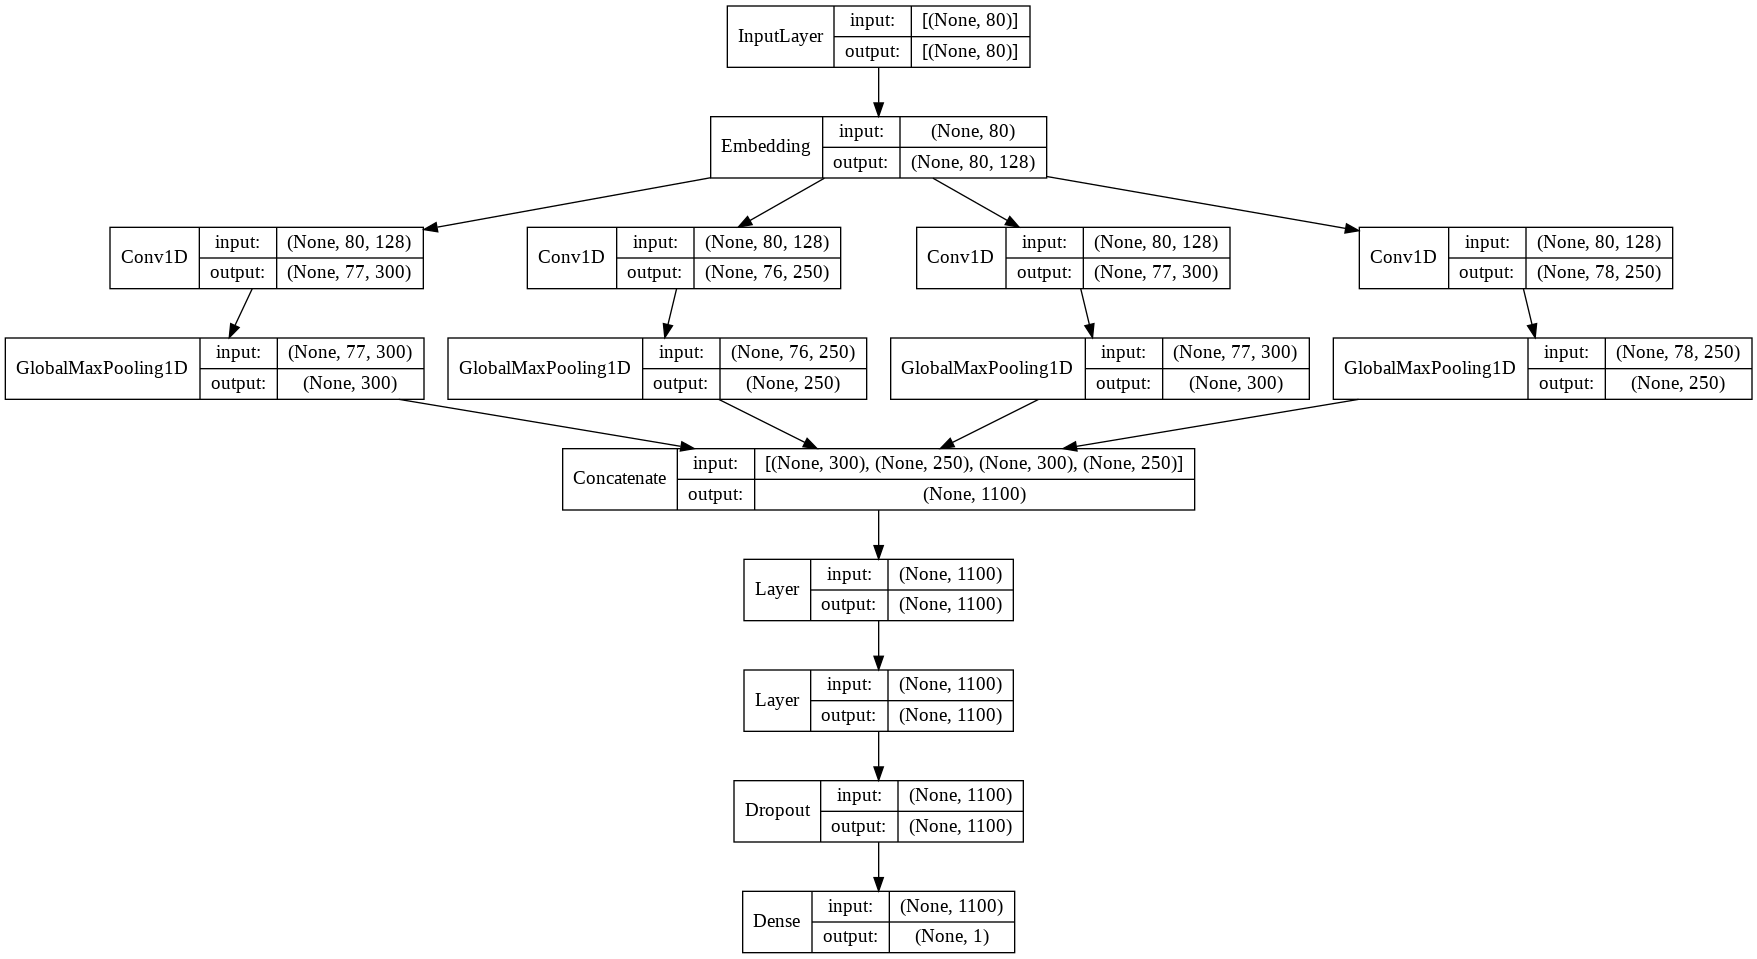

In [ ]:
from tensorflow.keras.utils import plot_model
 
model = tuner.hypermodel.build(best_hps)
 
#Plot Model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB')

In [ ]:
# Summary Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 128)      718720      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 77, 300)      153900      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 76, 250)      160250      embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
# Retrain model with the optimal hyperparameters
history = model.fit(x_train, y_train, batch_size=32, epochs = 10, validation_data = (x_test, y_test))

Epoch 1/10
117/117 [==============================] - 26s 214ms/step - loss: 4.6102 - accuracy: 0.6363 - val_loss: 3.5265 - val_accuracy: 0.6498
Epoch 2/10
117/117 [==============================] - 24s 208ms/step - loss: 2.8020 - accuracy: 0.6411 - val_loss: 2.1622 - val_accuracy: 0.6552
Epoch 3/10
117/117 [==============================] - 24s 207ms/step - loss: 1.7228 - accuracy: 0.7102 - val_loss: 1.3290 - val_accuracy: 0.8077
Epoch 4/10
117/117 [==============================] - 24s 209ms/step - loss: 1.0482 - accuracy: 0.8439 - val_loss: 0.8153 - val_accuracy: 0.8743
Epoch 5/10
117/117 [==============================] - 24s 209ms/step - loss: 0.6451 - accuracy: 0.8955 - val_loss: 0.5366 - val_accuracy: 0.8904
Epoch 6/10
117/117 [==============================] - 25s 210ms/step - loss: 0.4260 - accuracy: 0.9149 - val_loss: 0.3944 - val_accuracy: 0.8947
Epoch 7/10
117/117 [==============================] - 24s 207ms/step - loss: 0.3078 - accuracy: 0.9251 - val_loss: 0.3260 - val_ac

In [ ]:
# Plot grafik loss dan accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,5)
 
plt.show()

In [ ]:
## Evaluasi Model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

In [ ]:
## Penyimpanan Model
model.save('Data/model_CNN-BiLSTM_sentiment.h5')

# **Prediksi data baru**

In [ ]:
# Upload data yang akan diprediksi
new_data = pd.read_csv('https://raw.githubusercontent.com/Syamsyuriani/Scrapping_Data/main/Quipper-Data.csv')
new_data

,review
0,kalau bisa di perbarui lagi
1,KEREN!!!
2,Kalo yang udah daftar terus di login pake face...
3,Kode kelas tidak di temukan gimana nh min??? D...
4,"hai quipper video 😊 , saya ingin memberi masuk..."
...,...
93,Cacat quiper vidio gembel
94,Gak bisa buat SD ya? Hmmm...
95,Bikin belajar lebih mudah
96,Jawaban bener kok disalahin


In [ ]:
# Memuat kembali model
model = keras.models.load_model('Data/model_CNN-BiLSTM_sentiment.h5')

In [ ]:
# Tokenisasi dan pad sequencing
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(new_data['review'])
seq = tokenizer.texts_to_sequences(new_data['review'])
x_pred = keras.preprocessing.sequence.pad_sequences(seq, maxlen=80)
y_pred = model.predict(x_pred)

treshold = 0.5
for i in range(y_pred.shape[0]):
  if y_pred[i] > treshold:
    y_pred[i] = 1
  else:
    y_pred[i] = -1

new_data['label'] = y_pred

In [ ]:
# Hasil data yang telah diberi label
pd.set_option("max_colwidth", 100)
pd.set_option("max_rows", None)
new_data

,review,label
0,kalau bisa di perbarui lagi,1.0
1,KEREN!!!,-1.0
2,"Kalo yang udah daftar terus di login pake facebook gampang,,, tapi kok quipper sekarang makin jelek",-1.0
3,Kode kelas tidak di temukan gimana nh min??? Dan untuk smk di tambah dong!!!!,-1.0
4,"hai quipper video 😊 , saya ingin memberi masukan, lebih baik video yang sudah di unduh dan di si...",-1.0
5,"Mohon diperbaiki, setelah diupdate konten soal terkadang tidak bisa diunduh dengan sempurna kemu...",-1.0
6,Tambahin fitur tany Guru dong biar lebih paham lagi. Tapi semuanya udah bagus. Yang bilang jelek...,-1.0
7,"Masa gak ada pembahasan soal un materi buat un juga tidak ada , aneh sekali , banyak soal yang s...",-1.0
8,Gimana cari maga pelajaran yang pangen ditanya. Dan kenapa malah UN 2013 GAK ADA UN 2017 or 2016...,-1.0
9,"Quipper itu seperti aplikasi les belajar buat di rumah atau dimanapun dari hp, wajar saja kalau ...",-1.0


In [ ]:
neg = new_data[new_data['label']==-1].count()[0]
pos = new_data[new_data['label']==1].count()[0]

Text(0.5, 1.0, 'Diagram Lingkaran Data Analisis Sentimen')

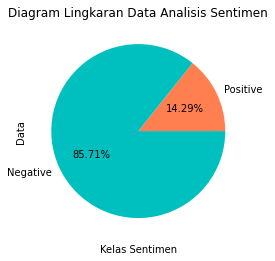

In [ ]:
labels = ['Positive','Negative']
Category1 = [str(pos),str(neg)]
plt.pie(Category1, labels=labels, autopct='%1.2f%%', colors=['coral', 'c'])
plt.xlabel('Kelas Sentimen')
plt.ylabel('Data')
plt.title('Diagram Lingkaran Data Analisis Sentimen')